# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features
X = pd.get_dummies(df, columns=[ # .get_dummies() converts categorical variables to binary
    "home_ownership",
    "verification_status",
    "issue_d",
    "pymnt_plan",
    "initial_list_status",
    "application_type",
    ]).drop(columns=["loan_status", "next_pymnt_d", "hardship_flag", "debt_settlement_flag"]) # Drop the columns we don't need for the features (we'll use the loan_status later as the target)

# Create our target
y = df.loan_status.to_frame() # Convert the loan_status column to a dataframe. We will use this later to calculate the accuracy of our model. 
# We will also use this to calculate the balanced accuracy of our model.
# loan_status is the column we want to predict. 

In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.373992,0.148001,0.371696,0.451066,0.177238,1.0,0.123879,0.876121,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.483865,0.355104,0.483261,0.497603,0.381873,0.0,0.329446,0.329446,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [7]:
# Check the balance of our target values
y['loan_status'].value_counts() 

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [9]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

In [10]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
data_scaler.fit(X_train, X_test)

StandardScaler()

In [21]:
# Scale the training and testing data
X_train = data_scaler.transform(X_train)
X_train[:5] # Check the first 5 rows of the scaled training data

X_test = data_scaler.transform(X_test)
X_test[:5] # Check the first 5 rows of the scaled testing data


array([[-1.62386501e+00, -1.31449961e+00, -1.67079132e+00,
        -7.17532749e-01, -1.11781992e+00,  3.17052689e+00,
        -1.51860089e+00, -2.24576781e+00, -1.48978884e+00,
        -8.04416013e-01, -1.99540490e+00, -1.60250604e+00,
        -1.60185565e+00, -8.09243893e-01, -8.09065566e-01,
        -6.01304982e-01, -1.11967294e+00, -6.30265328e-02,
         0.00000000e+00,  0.00000000e+00, -6.58675115e-01,
        -1.01148930e+00, -1.00000000e+00,  0.00000000e+00,
        -1.02466542e-01, -9.45657499e-01, -1.60585527e+00,
        -1.25394820e+00, -1.76689178e+00, -2.04277807e+00,
        -9.13208598e-01, -8.73757969e-01, -3.22415489e+00,
        -1.42179676e+00, -1.47641226e+00, -1.11095677e+00,
        -3.08220428e+00, -1.13594160e+00, -1.47680232e+00,
        -7.95648971e-01, -1.11707859e+00, -2.03175363e+00,
        -8.98630001e-01, -8.29781750e-01, -1.65187608e+00,
        -9.77783477e-01, -9.01589857e-03, -2.20521732e+00,
        -1.76407151e+00, -6.81126789e-01, -4.16974895e-0

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [12]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Initiate the model
rf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict with the model
y_pred = rf_model.predict(X_test)

In [13]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.7515253220831906

<AxesSubplot:>

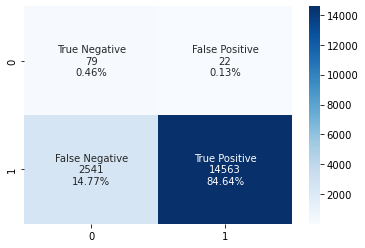

In [22]:
# Display the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Boilerplate code for plotting a confusion matrix heatmap
import seaborn as sns
group_names = ['True Negative','False Positive','False Negative','True Positive']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [15]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.63      0.87      0.05      0.74      0.54       101
   low_risk       1.00      0.87      0.63      0.93      0.74      0.56     17104

avg / total       0.99      0.87      0.64      0.92      0.74      0.56     17205



<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

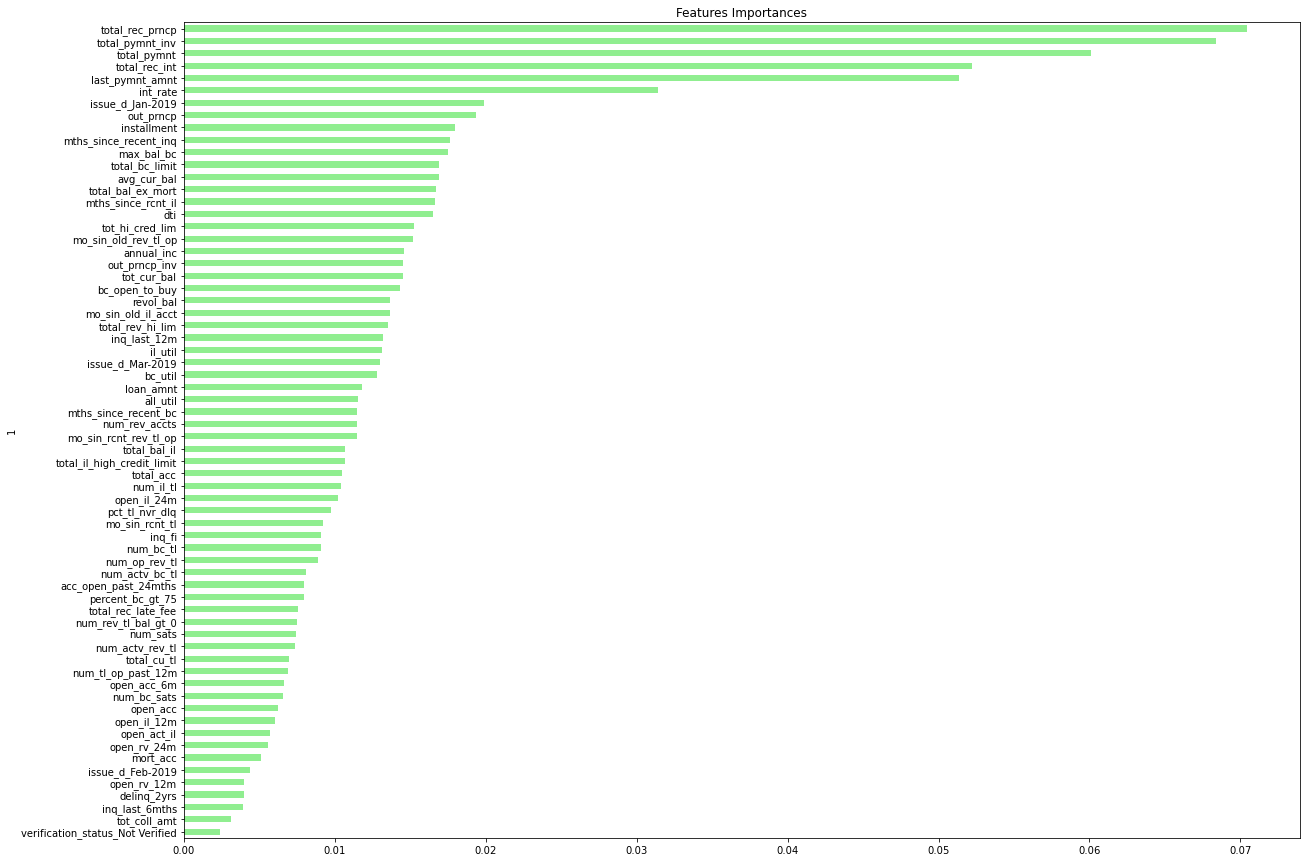

In [16]:
# List the features sorted in descending order by feature importance

# Set the features using feature_importances
importances = rf_model.feature_importances_

# Sort the features
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True) # zip() creates a list of tuples from two lists

# Plot the features
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)) # Create the initial datafraem. This will follow by several steps to manipulate the dataframe
importances_df.set_index(importances_df[1], inplace=True) # Set the index to the second column and inplace=True will overwrite the original dataframe
importances_df.drop(columns=1, inplace=True) # Drop the second column
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True) # Rename the first column to 'Feature Importances' using the .rename() method and a dictionary as the argument
importances_sorted = importances_df.sort_values(by='Feature Importances') # Replace the dataframe with a new sorted dataframe. Sort the dataframe by the 'Feature Importances' column
importances_sorted[25:].plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize=(20,15)) # Plot the dataframe with 25 rows and all columns

### Easy Ensemble Classifier

In [17]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1) 

# Fit the model
eec_model.fit(X_train, y_train)

# Predict with the model
y_pred = eec_model.predict(X_test)

In [18]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8168082389389547

<AxesSubplot:>

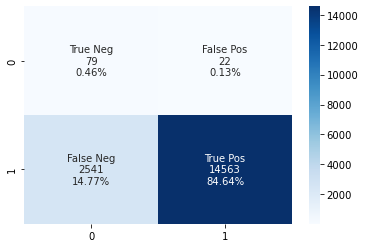

In [19]:
# Display the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Boilerplate code for plotting a confusion matrix heatmap
import seaborn as sns
group_names = ['True Negative','False Positive','False Negative','True Positive']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [20]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.78      0.85      0.06      0.82      0.66       101
   low_risk       1.00      0.85      0.78      0.92      0.82      0.67     17104

avg / total       0.99      0.85      0.78      0.91      0.82      0.67     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    The best balanced accuracy score was produced by the EasyEnsembleClassifier

2. Which model had the best recall score?

    The best recall score was produced by BalancedRandomForestClassifier even though this model had a large amount of false negatives or high recall. 

3. Which model had the best geometric mean score?

    The best geometric mean score was produced by EasyEnsembleClassifier

4. What are the top three features?

    total_rec_prncp, total_pymnt_inv, total_pymnt
    
